# Herron Topic 4 - Practice - Sec 04

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pandas_datareader as pdr
import scipy.optimize as sco # new addition for portfolio optimization
import yfinance as yf

In [2]:
%precision 4
pd.options.display.float_format = '{:.4f}'.format
# %config InlineBackend.figure_format = 'retina'

## Announcements

1. Please complete TRACE! I use TRACE to improve my treaching and courses, and I value your feedback. More here: <https://northeastern.instructure.com/courses/207607/discussion_topics/2753925>
2. Please plan for the in-class programming and MSFQ assessments on Tuesday, 4/15

## Five-Minute Recap

Please see the lecture notebook for an in-depth explanation of how we will use `sco.minimize()` for portfolio optimization.
Here are the key arguments to `sco.minimize()`:

1. `fun`: Name of function whose output we want to *minimize*
2. `x0`: First guess at inputs that *minimize* the output of the function in `fun`
3. `args`: A tuple of additional arguments to the function in `fun`
4. `bounds`: A list or tuple of tuples; For example, `((0, 1), (0, 1))` bounds inputs to fall between 0 and 1
5. `constraints`: A tuple of dictionaries with functions to constrain our inputs; For example, `{'type': 'eq', 'fun': lambda w: w.sum() - 1}` constraints te sum or our inputs to 1

##  Practice

### Find the maximum Sharpe Ratio portfolio of Mag 7 stocks over the last three years

Note that `sco.minimize()` finds *minimums*, so you need to minimize the *negative* Sharpe Ratio.

In [3]:
mag7 = (
    yf.download(
        tickers='GOOGL AAPL AMZN META MSFT NVDA TSLA',
        auto_adjust=False,
        progress=False
    )
    .iloc[:-1]
)

In [4]:
returns = mag7['Adj Close'].pct_change().iloc[-756:]

We need the risk-free rate of return to calculate Sharpe ratios.
French provides the risk-free rate of return as `RF` in most of his data sets.

In [5]:
ff3 = (
    pdr.DataReader(
        name='F-F_Research_Data_Factors_daily',
        data_source='famafrench',
        start='1900'
    )
    [0]
    .div(100)
)

C:\Users\r.herron\AppData\Local\Temp\ipykernel_12592\582763811.py:2: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  pdr.DataReader(


The Sharpe ratio is the ratio of the mean portfolio *excess* return to the volatility of portfolio *excess* returns.
$$
S_p = \frac{\overline{r_p - r_f}}{\sigma(r_p - r_f)}
$$
We can simplify this calculation if we calculate a data frame of *excess* returns.
Then, we can use this data frame of excess returns to define the covariance matrix and mean returns.

In [6]:
returns_excess = returns.sub(ff3['RF'], axis=0)
Sigma_excess = returns_excess.cov()
mu_excess = returns_excess.mean()

In [7]:
def Sharpe(w, Sigma_excess, mu_excess, ppy=252):
    top = ppy * w.T @ mu_excess
    bot = np.sqrt(ppy * w.T @ Sigma_excess @ w)
    return top / bot

In [8]:
def Sharpe_neg(w, Sigma_excess, mu_excess, ppy=252):
    return -1 * Sharpe(w=w, Sigma_excess=Sigma_excess, mu_excess=mu_excess, ppy=252)

In [9]:
def equal_weights(n):
    return np.ones(n) / n

In [10]:
equal_weights(Sigma_excess.shape[0])

array([0.1429, 0.1429, 0.1429, 0.1429, 0.1429, 0.1429, 0.1429])

In [11]:
[(0, 1) for _ in range(Sigma_excess.shape[0])]

[(0, 1), (0, 1), (0, 1), (0, 1), (0, 1), (0, 1), (0, 1)]

We can store our `minimize()` results in `res_X` and increment `X` for each of the following practices.

In [12]:
res_1 = sco.minimize(
    fun=Sharpe_neg,
    x0=equal_weights(Sigma_excess.shape[0]),
    args=(Sigma_excess, mu_excess),
    bounds=[(0, 1) for _ in range(Sigma_excess.shape[0])],
    constraints=(
        {'type': 'eq', 'fun': lambda w: w.sum() - 1}
    )
)

We want to make sure that `minimize()` finds a solution (i.e., `res_1['success']` is `True`).
The *negative* Sharpe ratio is the value for the `fun` key, and the portfolio weights are the value for the `x` key.

In [13]:
res_1

 message: Optimization terminated successfully
 success: True
  status: 0
     fun: -1.2870714577713982
       x: [ 3.868e-17  0.000e+00  0.000e+00  3.112e-01  0.000e+00
            6.888e-01  2.186e-17]
     nit: 5
     jac: [ 1.513e-01  3.676e-01  2.966e-01 -3.821e-04  2.482e-01
            1.726e-04  3.065e-01]
    nfev: 40
    njev: 5

We can save these results to a data frame for easy updating and plotting.

In [14]:
res_df = pd.DataFrame(
    data={'Long Only': res_1['x']},
    index=Sigma_excess.columns
)

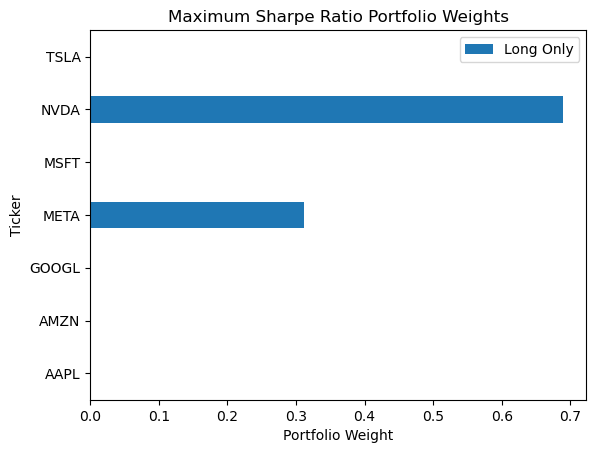

In [15]:
res_df.plot(kind='barh')
plt.title('Maximum Sharpe Ratio Portfolio Weights')
plt.xlabel('Portfolio Weight')
plt.show()

### Find the maximum Sharpe Ratio portfolio of Mag 7 stocks over the last three years, but allow short weights up to 10% on each stock

We see that the long-only constraint was binding, and relaxing it leads to several short positions and bigger positions in NVDA and META.

In [16]:
res_2 = sco.minimize(
    fun=Sharpe_neg,
    x0=equal_weights(Sigma_excess.shape[0]),
    args=(Sigma_excess, mu_excess),
    bounds=[(-0.1, 1.6) for _ in range(Sigma_excess.shape[0])],
    constraints=(
        {'type': 'eq', 'fun': lambda w: w.sum() - 1}
    )
)

In [17]:
res_df['Shorts up to 10% Each'] = res_2['x']

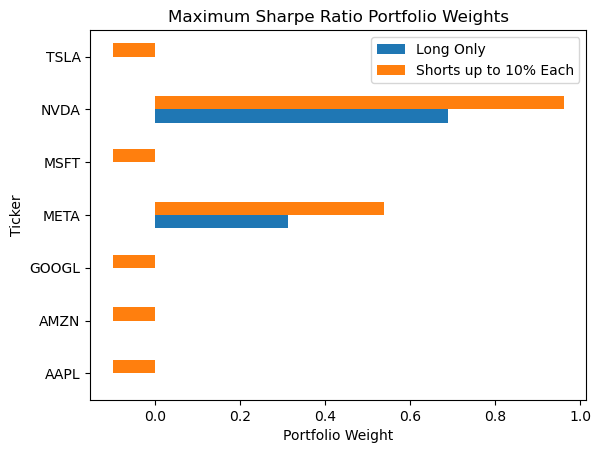

In [18]:
res_df.plot(kind='barh')
plt.title('Maximum Sharpe Ratio Portfolio Weights')
plt.xlabel('Portfolio Weight')
plt.show()

### Find the maximum Sharpe Ratio portfolio of Mag 7 stocks over the last three years, but allow total short weights of up to 30%

In [19]:
toy = np.arange(-2, 3)

In [20]:
toy[toy < 0].sum()

np.int64(-3)

In [21]:
res_3 = sco.minimize(
    fun=Sharpe_neg,
    x0=equal_weights(Sigma_excess.shape[0]),
    args=(Sigma_excess, mu_excess),
    bounds=[(-0.3, 1.3) for _ in range(Sigma_excess.shape[0])],
    constraints=(
        {'type': 'eq', 'fun': lambda w: w.sum() - 1},
        {'type': 'ineq', 'fun': lambda w: w[w < 0].sum() + 0.3}
    )
)

In [22]:
res_df['Shorts up to 30% Total'] = res_3['x']

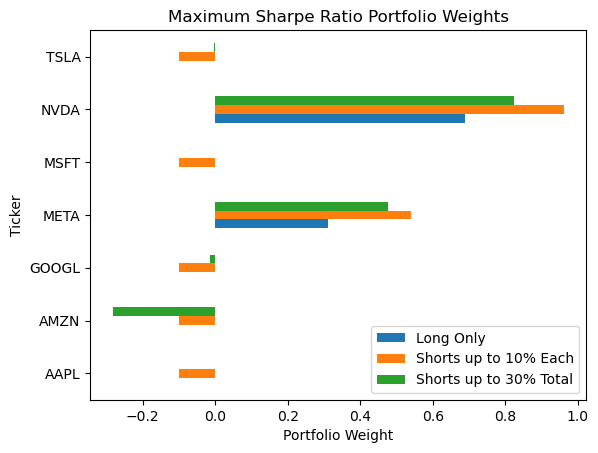

In [23]:
res_df.plot(kind='barh')
plt.title('Maximum Sharpe Ratio Portfolio Weights')
plt.xlabel('Portfolio Weight')
plt.show()

::: {.callout-note}
Try the next two practices before we meet on Friday.
:::

### Find the maximum Sharpe Ratio portfolio of Mag 7 stocks over the last three years, but do not allow any weight to exceed 30% in magnitude

### Find the minimum 95% Value at Risk (Var) portfolio of Mag 7 stocks over the last three years

More on VaR [here](https://en.wikipedia.org/wiki/Value_at_risk).

### Find the minimum draw down portfolio of Mag 7 stocks over the last three years

### Find the minimum draw down portfolio for the sample with complete data for the current Dow-Jones Industrial Average (DJIA) stocks

You can find the [DJIA tickers on Wikipedia](https://en.wikipedia.org/wiki/Dow_Jones_Industrial_Average).

### Plot the minimum-variance frontier for the sample with complete data for the current the DJIA stocks

### Find the maximum Sharpe Ratio portfolio for the sample with complete data for the current the DJIA stocks